## Post-processing Interferograms from ALOS-2

```bash
cd ~/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220
screen -S ALOS2_A184 -L
load_insar
alos2App.py alos2App.xml --steps --end=ion_unwrap
```

In [6]:
%matplotlib inline
import os
import numpy as np
import platform
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt, ticker
from mintpy.utils import ptime, readfile, writefile, plot as pp, utils as ut, isce_utils
from mintpy.cli import view, subset, prep_isce, mask, geocode
from skimage.transform import resize
plt.rcParams.update({'font.size': 12})
cmy = pp.ColormapExt('cmy').colormap

#dname = 'ALOS2_A184_20220905_20230220';  sub_str = '-y 3000 8000'
dname = 'ALOS2_D077_20220916_20230217';  sub_str = '-y 500 5500'

if platform.system() == 'Linux':
    proj_dir = os.path.expanduser('~/data/2023TurkeyEQ')
    work_dir = os.path.join(proj_dir, dname, 'insar/sub')
else:
    proj_dir = os.path.expanduser('~/data/archives/2023TurkeyEQ')
    work_dir = os.path.join(proj_dir, dname, 'insar')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# input/output files
gmt_lonlat_files = [os.path.join(proj_dir, f'USGS/simple_fault_{x}.lonlat') for x in ['confident', 'queried']]
date1, date2 = ptime.yymmdd(dname.split('_')[-2:])
fbase = f'{date1}-{date2}_5rlks_28alks'

int_file = f'filt_{fbase}.int'
cor_file = f'filt_{fbase}.cor'
unw_file = f'filt_{fbase}.unw'
lat_file = f'{fbase}.lat'
lon_file = f'{fbase}.lon'
wbd_file = f'{fbase}.wbd'
msk_file = f'{fbase}.msk'

dem_file = os.path.join(proj_dir, 'DEM/demLat_N35_N42_Lon_E034_E041_90m.h5')
flt_file = os.path.join(proj_dir, 'USGS/simple_fault_confident.lonlat')

Go to directory: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_D077_20220916_20230217/insar


In [16]:
def generate_mask4earthquake_rupture(gmt_lonlat_files, int_file, msk_file, lookup_file, rupture_width=20):
    """Generate mask for earthquake ruptures, to facilitae the phase unwrapping of co-seismic deformation.

    Parameters: rupture_files - list(str), path to the text file of rupture traces in GMT lonlat format
                int_file      - str, path to the interferogram
                msk_file      - str, path to the output mask file
                lookup_file   - list(str), path to the lookup table files, e.g.:
                                'geometryRadar.h5', or 
                                ['lat.rdr', 'lon.rdr']
                rupture_width - int, surface rupture width in pixels
    Returns:    msk_file      - str, path to the output mask file
    """
    work_dir = os.path.dirname(os.path.abspath(int_file))
    # go to work directory
    os.chdir(work_dir)
    print('Go to directory:', work_dir)

    # read EQ rupture trace files
    faults_lola = []
    for gmt_lonlat_file in gmt_lonlat_files:
        print(f'read fault lat/lon from file: {gmt_lonlat_file}')
        faults_lola += readfile.read_gmt_lonlat_file(gmt_lonlat_file, min_dist=0)

    # translate lat/lon into local X/Y coordinates
    atr = readfile.read_attribute(int_file)
    coord = ut.coordinate(atr, lookup_file=lookup_file)
    faults_xy = []
    num_fault = len(faults_lola)
    print('translating lat/lon into local X/Y coordiantes...')
    prog_bar = ptime.progressBar(maxValue=num_fault)
    for i, fault_lola in enumerate(faults_lola):
        prog_bar.update(i+1, suffix=f'fault {i+1}/{num_fault} ({fault_lola.shape[0]} points)')
        # translate point-by-point to keep faults with partial points outside of the coverage
        fault_xy = []
        for j in range(fault_lola.shape[0]):
            try:
                y, x = coord.geo2radar(fault_lola[j,1], fault_lola[j,0])[:2]
                fault_xy.append((x, y))
            except:
                pass
        if fault_xy:
            faults_xy.append(fault_xy)
    prog_bar.close()

    # rasterize
    # link: https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html
    print(f'rasterize local X/Y coordiantes with a width of {rupture_width} pixels')
    length, width = int(atr['LENGTH']), int(atr['WIDTH'])
    img = Image.new('L', (int(width), int(length)), 1)
    for i, fault_xy in enumerate(faults_xy):
        ImageDraw.Draw(img).line(fault_xy, fill=0, width=rupture_width, joint='curve')
    msk = np.array(img, dtype=np.bool_)

    # write to file
    meta = dict(atr)
    meta['FILE_TYPE'] = '.msk'
    meta['DATA_TYPE'] = 'bool'
    meta['BANDS'] = 1
    writefile.write(msk, out_file=msk_file, metadata=meta, ref_file=cor_file)
    print(f'write mask to file: {msk_file}')

    # plot
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 6])
    ax = axs[0]
    for i, fault in enumerate(faults_lola):
        ax.plot(fault[:,0], fault[:,1], label=i+1)
    ax.set_aspect('equal')
    ax.legend(ncol=3)
    ax = axs[1]
    im = ax.imshow(msk, cmap='gray', interpolation='nearest')
    pp.auto_flip_direction(atr, ax=ax)
    fig.colorbar(im, ax=ax, shrink=0.5)
    plt.show()

    return msk_file

print('warm up utils functioins.')

warm up utils functioins.


## 1. Ionospheric correction

Re-run phase unwrapping for ion estimation, by masking out the near-field ruptures, to avoid PU errors.

Go to directory: /home/zhangyunjun/data/2023TurkeyEQ/ion/ion_cal
extract metadata from ISCE/alosStack xml file: ../../220905.track.xml
writing  ../../data.rsc
preparing RSC file for geometry files
preparing RSC file for: /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220/ion/ion_cal/lower_80rlks_224alks.int
Done.
Go to directory: /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220/ion/ion_cal
read fault lat/lon from file: /home/zhangyunjun/data/2023TurkeyEQ/USGS/simple_fault_confident.lonlat
read fault lat/lon from file: /home/zhangyunjun/data/2023TurkeyEQ/USGS/simple_fault_queried.lonlat
translating lat/lon into local X/Y coordiantes...
[==================================================] fault 33/33 (8 points)    1s /     0ss 
rasterize local X/Y coordiantes with a width of 5 pixels
write file: /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220/ion/ion_cal/msk_80rlks_224alks.msk
write file: /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_202209

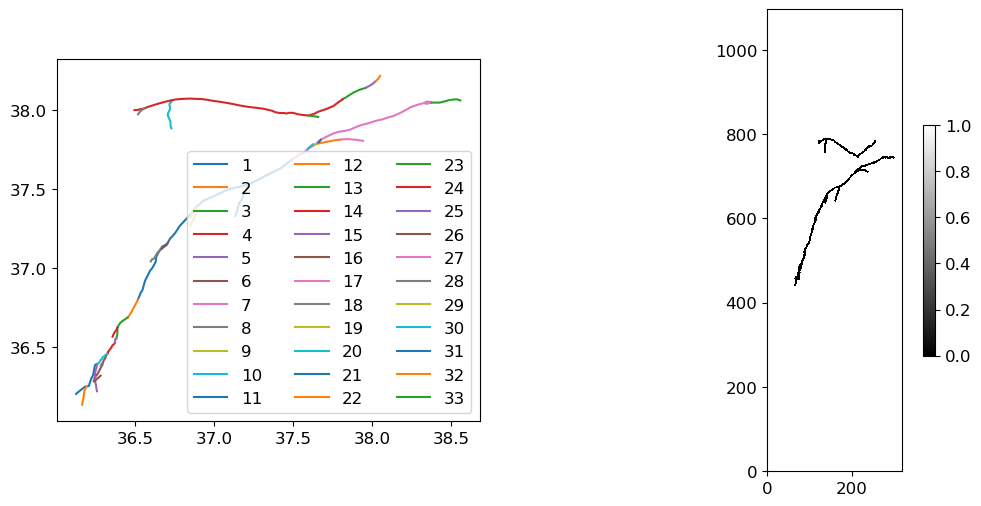

'/home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220/ion/ion_cal/msk_80rlks_224alks.msk'

In [17]:
# work dir
os.chdir(os.path.join(proj_dir, dname, 'ion/ion_cal'))
print('Go to directory:', os.path.join(proj_dir, 'ion/ion_cal'))

# generate mask for EQ ruptures
mli_str = '80rlks_224alks'
rupture_width = 5
ion_lookup_file = [f'lat_{mli_str}.lat', f'lon_{mli_str}.lon']
ion_msk_file = os.path.abspath(f'msk_{mli_str}.msk')
ion_int_file = os.path.abspath(f'lower_{mli_str}.int')

prep_isce.main(f'-f {ion_int_file} -m ../../2*.track.xml -g ./'.split())
generate_mask4earthquake_rupture(gmt_lonlat_files, int_file=ion_int_file, msk_file=ion_msk_file, lookup_file=ion_lookup_file, rupture_width=rupture_width)

In [21]:
os.chdir(os.path.join(proj_dir, dname, 'ion/ion_cal'))
print(f'cd {os.path.join(proj_dir, dname, "ion/ion_cal")}')
print(f'screen -S {dname.split("_")[1]}_UNW -L\nload_insar')

for suffix in ['lower', 'upper']:
    ion_int_file = f'{suffix}_{mli_str}.int'
    ion_cor_file = f'{suffix}_{mli_str}.phsig'
    ion_unw_file = f'{suffix}_{mli_str}.unw'
    # prepare metadata
    prep_isce.main(f'-f {os.path.abspath(ion_int_file)} -m ../../2*.track.xml -g ./'.split())
    # unwrap cmd
    cmd = f'unwrap.py -i {ion_int_file} -c {ion_cor_file} -o {ion_unw_file} --mask {ion_msk_file} '
    cmd += '--max-comp 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO '
    print(cmd)
    os.system(cmd)

# re-run alos2App
print('\n'+'-'*50)
os.chdir(os.path.join(proj_dir, dname))
print(f'cd {os.path.join(proj_dir, dname)}')
cmd = 'alos2App.py alos2App.xml --steps --start=ion_filt --end=filt'
print(cmd)
os.system(cmd)

cd /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220/ion/ion_cal
screen -S A184_UNW -L
load_insar
['../../data.rsc'] exists and is newer than ['../../220905.track.xml'] --> skip.
preparing RSC file for geometry files
preparing RSC file for: /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220/ion/ion_cal/lower_80rlks_224alks.int
Done.
unwrap.py -i lower_80rlks_224alks.int -c lower_80rlks_224alks.phsig -o lower_80rlks_224alks.unw --mask /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220/ion/ion_cal/msk_80rlks_224alks.msk --max-comp 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO 
['../../data.rsc'] exists and is newer than ['../../220905.track.xml'] --> skip.
preparing RSC file for geometry files
preparing RSC file for: /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220/ion/ion_cal/upper_80rlks_224alks.int
Done.
unwrap.py -i upper_80rlks_224alks.int -c upper_80rlks_224alks.phsig -o upper_80rlks_224alks.unw --mask /ho

*** Weighted power spectrum interferogram filter v1.0 clw 19-Feb-97 ***
#lines in the interferogram file: 8781
progress: 100%

GDAL open (R): filt_220905-230220_5rlks_28alks.int.vrt
GDAL close: filt_220905-230220_5rlks_28alks.int.vrt
args:  Namespace(hh=None, equation='a*abs(b)', out='filt_220905-230220_5rlks_28alks.int', scheme='BSQ', dtype='cfloat', debug=False, noxml=False)
files:  ['--a=tmp.int', '--b=diff_220905-230220_5rlks_28alks.int']
spectrum weighting exponent:   0.8000
FFT window size:    32
range and azimuth step size (pixels):     4
array width, height, offset:  5141  8781     0

number of lines written to file: 8784


user time    (s):      77.370
system time  (s):       0.350
elapsed time (s):      77.750

GDAL open (R): filt_220905-230220_5rlks_28alks.int.vrt
GDAL open (R): 220905-230220_5rlks_28alks.amp.vrt
API open (WR): 220905-230220_5rlks_28alks.phsig

 << PS filtering >>


 interferogram width:  5141  number of lines/patch:  3700
 start line:        1  number of lines:    8781
 start sample:      1  end sample:         5141
 wisdomFile, length =            0

 azimuth buffer size:         

0

## [skip] 2. Interferogram filtering + geocode + coherence estimation

Skip as the SNAPHU defo mode seems to work better in radar coordinate?

### 2.1 re-run filtering via `alos2App.py`

```bash
cd ~/data/2023TurkeyEQ/ALOS2_A183_20190918_20230215
alos2App.py alos2App.xml --steps --dostep=filt
```

### 2.2 Geocode interferogram + coherence estimation

In [80]:
#!prep_isce.py -f filt_190918-230215_2rlks_14alks.int -m ./../190918.track.xml -g ./
!geocode.py filt_190918-230215_2rlks_14alks.int --lat-file 190918-230215_2rlks_14alks.lat --lon-file 190918-230215_2rlks_14alks.lon
isce_utils.estimate_coherence('geo_filt_190918-230215_2rlks_14alks.int', 'geo_filt_190918-230215_2rlks_14alks.cor')

No lookup table (longitude or rangeCoord) found in files.
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: 190918-230215_2rlks_14alks.lat
calculate output pixel size using option 1 (same pixel area before/after resampling)
output pixel size in (lat, lon) in degree: (-0.0002666413056464435, 0.00039686341342079127)
output area extent in (S, N, W, E) in degree: (36.18023161869967, 39.9041440933579, 36.076293877863606, 40.76166333670947)
output file row / column number: (13966, 11806)
[1/1] preparing geometry for dest_box: (0, 0, 11806, 13966) --> full src_box: (0, 0, 12822, 9891)
--------------------------------------------------
resampling file: filt_190918-230215_2rlks_14alks.int
--------------------------------------------------1/1
reading complex in block (0, 0, 12822, 9891) from filt_190918-230215_2rlks_14alks.int ...
nearest resampling with pyresample.kd_tree using 1 CPU cores in 166 segments ...
write file: geo_filt

## 3. Phase unwrapping

### 3.1 Subset

In [22]:
# go to sub directory
os.chdir(work_dir)
print('Go to directory:', work_dir)

# subset int file
subset.main(f'../{int_file} {sub_str} -o ./{int_file}'.split())

# subset geometry files
for fext in ['hgt', 'ion', 'lat', 'lon', 'los', 'wbd']:
    fname = f'{fbase}.{fext}'
    subset.main(f'../{fname} {sub_str} -o ./{fname}'.split())

# prepare meta and cor file
prep_isce.main(f'-f {int_file} -m ../../2*.track.xml -g ../'.split())
isce_utils.estimate_coherence(int_file, cor_file)

Go to directory: /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar/sub
------------------------------
subset .int file: ../filt_220905-230220_5rlks_28alks.int ...
data   range in (x0,y0,x1,y1): (0, 0, 5141, 8781)
subset range in (x0,y0,x1,y1): (0, 3000, 5141, 8000)
data   range in (W, N, E, S): None
subset range in (W, N, E, S): None
writing >>> ./filt_220905-230220_5rlks_28alks.int
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 0/3000/5141/8000
reading complex in (0, 3000, 5141, 8000) from filt_220905-230220_5rlks_28alks.int ...
write file: ./filt_220905-230220_5rlks_28alks.int
write file: ./filt_220905-230220_5rlks_28alks.int.rsc
write file: ./filt_220905-230220_5rlks_28alks.int.xml
write file: ./filt_220905-230220_5rlks_28alks.int.vrt
------------------------------
subset .hgt file: ../220905-230220_5rlks_28alks.hgt ...
data   range in (x0,y0,x1,y1): (0, 0, 5141, 8781)
subset range in (x0,y0,x1,y1): (0, 3000, 5141, 8000)
data   range in (W, 

### 3.2 Generate mask for EQ ruptures

+ exclude fault rupture traces
+ [skip] exclude water body. Skipped as water body is not large & not in the near field -> not a problem for PU.
+ [skip] exclude very low coherent pixels. Skipped to let SNAPHU handle it.

Go to directory: /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar/sub
read fault lat/lon from file: /home/zhangyunjun/data/2023TurkeyEQ/USGS/simple_fault_confident.lonlat
read fault lat/lon from file: /home/zhangyunjun/data/2023TurkeyEQ/USGS/simple_fault_queried.lonlat
translating lat/lon into local X/Y coordiantes...
[==================================================] fault 33/33 (8 points)   57s /     1ss 
rasterize local X/Y coordiantes with a width of 20 pixels
write file: 220905-230220_5rlks_28alks.msk
write file: 220905-230220_5rlks_28alks.msk.rsc
write mask to file: 220905-230220_5rlks_28alks.msk
ASCENDING orbit -> flip up-down


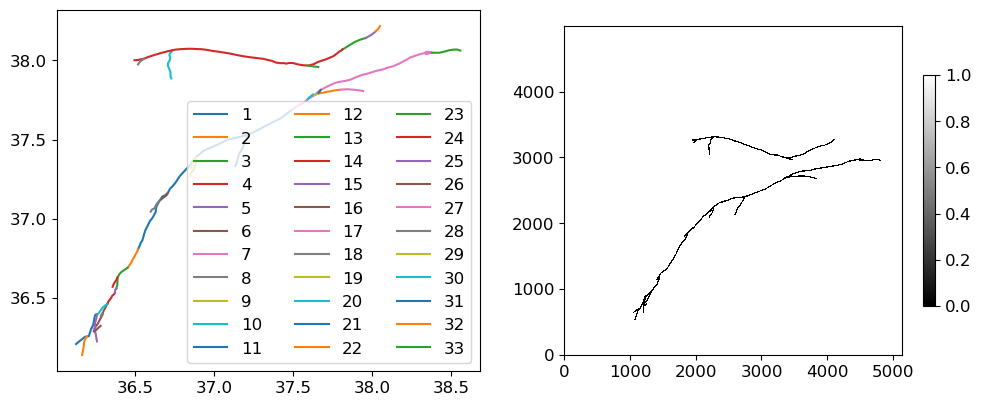

'220905-230220_5rlks_28alks.msk'

In [23]:
gmt_lonlat_files = [os.path.join(proj_dir, f'USGS/simple_fault_{x}.lonlat') for x in ['confident', 'queried']]
generate_mask4earthquake_rupture(gmt_lonlat_files, int_file=int_file, msk_file=msk_file, lookup_file=[lat_file, lon_file])

#### [skip] 3.2.2 Exclude pixels on water

In [ ]:
# generate water body file in geo-coordinates
#!prep_isce.py -f 190918-230215_2rlks_14alks.wbd -m ./../190918.track.xml -g ./
#!geocode.py 190918-230215_2rlks_14alks.wbd --lat-file 190918-230215_2rlks_14alks.lat --lon-file 190918-230215_2rlks_14alks.lon

# update mask based on water body
wbd = readfile.read(wbd_file)[0]
msk[wbd!=0] = 0

# plot
fig, ax = plt.subplots(figsize=[8, 8])
im = ax.imshow(msk, cmap='gray', interpolation='nearest')
pp.auto_flip_direction(atr, ax=ax)
fig.colorbar(im, ax=ax, shrink=0.5)
plt.show()

#### [skip] 3.2.3 Exclude pixels with low coherence

In [ ]:
# update mask based on water body
cor, meta = readfile.read(cor_file)
cor[cor == 0] = np.nan
#msk[water_body!=0] = 0

# stats on the coherence
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 2.5])
im = ax.hist(cor.flatten(), bins=50)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlabel('coherence')

# update mask based on coherence
msk[cor < 0.25] = 0

# plot
fig, ax = plt.subplots(figsize=[8, 8])
im = ax.imshow(msk, cmap='gray', interpolation='nearest')
fig.colorbar(im, ax=ax, shrink=0.5)
plt.show()

### 3.3 Re-run phase unwrapping

In [24]:
print(f'cd {work_dir}')
print(f'screen -S {dname.split("_")[1]}_UNW -L\nload_insar')
cmd = f'unwrap.py -i {int_file} -c {cor_file} -o {unw_file} --mask {msk_file} '
cmd += '--max-comp 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO '
print(cmd)

cd /home/zhangyunjun/data/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar/sub
screen -S A184_UNW -L
load_insar
unwrap.py -i filt_220905-230220_5rlks_28alks.int -c filt_220905-230220_5rlks_28alks.cor -o filt_220905-230220_5rlks_28alks.unw --mask 220905-230220_5rlks_28alks.msk --max-comp 20 --defo-max 10 --init-only --init-method MCF --cost-mode DEFO 


## 4. Mask and geocode

Copy files from `insar/sub` on cluster to `insar` on laptop.

In [2]:
work_dir = os.path.join(proj_dir, dname, 'insar')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# mask
mask.main(f'{unw_file}.conncomp -m {wbd_file} --mask-vmax 1 --fill 0'.split())
mask.main(f'{unw_file} -m {unw_file}_msk.conncomp'.split())
mask.main(f'{fbase}.ion -m {wbd_file} --mask-vmax 1'.split())

# geocode
S, N, W, E = 35.3, 39.0, 35.0, 39.5   # same as Fig. 1
step = 0.000833334                    # deg (90 m), set to None to calculate product resolution for reference
!mkdir -p geo

opt = f'--lat-file {lat_file} --lon-file {lon_file} --fill nan --bbox {S} {N} {W} {E} --lalo-step -{step} {step}'
geocode.main(f'filt_{fbase}_msk.unw -o ./geo/geo_filt_msk.unw {opt}'.split())
geocode.main(f'filt_{fbase}.cor -o ./geo/geo_filt.cor {opt}'.split())
geocode.main(f'{fbase}.los -o ./geo/los.geo {opt}'.split())
geocode.main(f'{fbase}_msk.ion -o ./geo/ion_msk.geo {opt}'.split())

# spatial reference
!reference_point.py ./geo/geo_filt_msk.unw --lat 36.3 --lon 38.5
print('Done.')

Go to directory: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar
mask out pixels with value > 1.0 in mask file
masking band1 from filt_220905-230220_5rlks_28alks.unw.conncomp ...
write file: filt_220905-230220_5rlks_28alks.unw_msk.conncomp
write file: filt_220905-230220_5rlks_28alks.unw_msk.conncomp.rsc
masking magnitude from filt_220905-230220_5rlks_28alks.unw ...
masking phase     from filt_220905-230220_5rlks_28alks.unw ...
write file: filt_220905-230220_5rlks_28alks_msk.unw
write file: filt_220905-230220_5rlks_28alks_msk.unw.rsc
mask out pixels with value > 1.0 in mask file
masking magnitude from 220905-230220_5rlks_28alks.ion ...
masking phase     from 220905-230220_5rlks_28alks.ion ...
write file: 220905-230220_5rlks_28alks_msk.ion
write file: 220905-230220_5rlks_28alks_msk.ion.rsc
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: 220905-230220_5rlks_28alks.lat
output pixel size in (lat

## 5. Correct for troposphere and solid Earth tides

In [4]:
from mintpy.cli import load_data, smallbaselineApp
# write geometry HDF5 file
config = f"""# vim: set filetype=cfg:
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
mintpy.load.processor        = isce
##---------for ISCE only:
mintpy.load.metaFile         = {os.path.join(proj_dir, dname, f'{date1}.track.xml')}
mintpy.load.baselineDir      = None
##---------geometry datasets:
mintpy.load.demFile          = {os.path.join(work_dir, f'{fbase}.hgt')}
mintpy.load.lookupYFile      = {os.path.join(work_dir, f'{fbase}.lat')}
mintpy.load.lookupXFile      = {os.path.join(work_dir, f'{fbase}.lon')}
mintpy.load.incAngleFile     = {os.path.join(work_dir, f'{fbase}.los')}
mintpy.load.azAngleFile      = {os.path.join(work_dir, f'{fbase}.los')}
"""
sname, oname = dname.split('_')[:2]
config_file = os.path.join(work_dir, f'{sname}_{oname}.txt')
print('write MintPy configuration to file: {}'.format(config_file))
with open(config_file, "w") as fid:
    fid.write(config)
smallbaselineApp.main(f'{config_file} -g'.split())
# write geometryRadar.h5
load_data.main(f'-t smallbaselineApp.cfg --geom'.split())
# write geometryGeo.h5
geocode.main(f'./inputs/geometryRadar.h5 -o ./geo/geometryGeo.h5 {opt}'.split())

write MintPy configuration to file: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar/ALOS2_A184.txt
--------------------------------------------------
Project name: ALOS2_A184
Go to work directory: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar
read custom template file: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar/ALOS2_A184.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar/smallbaselineApp.cfg
copy ALOS2_A184.txt       to inputs   directory for backup.
copy ALOS2_A184.txt       to pic      directory for backup.
read default template file: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar/smallbaselineApp.cfg
Go back to directory: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_A184_20220905_20230220/insar

######################################

In [12]:
# add required metadata for phase corrections
meta = readfile.read_roipac_rsc(os.path.join(proj_dir, dname, 'data.rsc'))
meta['DATE12'] = f'{date1}-{date2}'
ut.add_attribute('./geo/geo_filt_msk.unw', meta)

'./geo/geo_filt_msk.unw'

In [2]:
!tropo_pyaps3.py -f ./geo/geo_filt_msk.unw -g ./geo/geometryGeo.h5

weather model: ERA5 - dry (hydrostatic) and wet delay
weather directory: /Users/yunjunz/data/aux
output tropospheric delay     time-series file: ./geo/ERA5.h5
output corrected displacement time-series file: ./geo/geo_filt_msk_ERA5.unw
read dates/time info from file: ./geo/geo_filt_msk.unw
time of cloest available product: 21:00 UTC

--------------------------------------------------------------------------------
Download global atmospheric model files...
update mode: ON
output file: ./geo/ERA5.h5
1) output file exists and is newer than all GRIB files.
2) output file has the same len/wid as the geometry file and contains all dates
3) output file is fully written.
run or skip: skip
Skip downloading and use existed troposhperic delay HDF5 file: ./geo/ERA5.h5.

--------------------------------------------------------------------------------
Calculate tropospheric delay and write to HDF5 file...
update mode: ON
output file: ./geo/ERA5.h5
1) output file exists and is newer than all GRIB file

In [3]:
!solid_earth_tides.py ./geo/geo_filt_msk_ERA5.unw -g ./geo/geometryGeo.h5

prepare LOS geometry in geo-coordinates from file: ./geo/geometryGeo.h5
read incidenceAngle from file: ./geo/geometryGeo.h5
read azimuthAngle   from file: ./geo/geometryGeo.h5
get the unit vector for enu2los projection with mean value: E = -0.613, N = -0.107, U = 0.775.

--------------------------------------------------
calculating solid Earth tides using PySolid (Milbert, 2018; Yunjun et al., 2022) ...
[==================================================] 2023-02-20T21:28:28 (2/2)    2s /     2s
delete exsited file: ./geo/SET.h5
create HDF5 file: ./geo/SET.h5 with w mode
create dataset /timeseries of float32    in size of (2, 4440, 5400)      with compression=None
create dataset /date       of |S8        in size of (2,)                 with compression=None
create dataset /sensingMid of |S15       in size of (2,)                 with compression=None
finished writing to ./geo/SET.h5
correcting tide for using diff.py
diff.py ./geo/geo_filt_msk_ERA5.unw ./geo/SET.h5 -o ./geo/geo_filt_ms

## 6. Plot

run view.py in MintPy version 1.5.1.post35, date 2023-05-24
input file is isce .unw file: /Users/yunjunz/data/archives/2023TurkeyEQ/ALOS2_D077_20220916_20230217/insar/geo/geo_filt_msk_ERA5_SET.unw in float32 format
file size in y/x: (4440, 5400)
input dataset: "['phase']"
num of datasets in file geo_filt_msk_ERA5_SET.unw: 2
datasets to exclude (0):
[]
datasets to display (1):
['phase']
data   coverage in y/x: (0, 0, 5400, 4440)
subset coverage in y/x: (0, 0, 5400, 4440)
data   coverage in lat/lon: (35.0, 39.0, 39.5000036, 35.29999704)
subset coverage in lat/lon: (35.0, 39.0, 39.5000036, 35.29999704)
------------------------------------------------------------------------
area exceed 2000 pixels, turn off default DEM contour display
colormap: RdBu
initiate cartopy map projection: PlateCarree
figure title: ALOS2_D077_20220916_20230217_IFG
figure size : [9.12, 6.00]
reading data ...
Apply math operation: reverse
data    range: [-2.379772, 3.748978] m
display range: [-3.0, 3.0] m
reading D

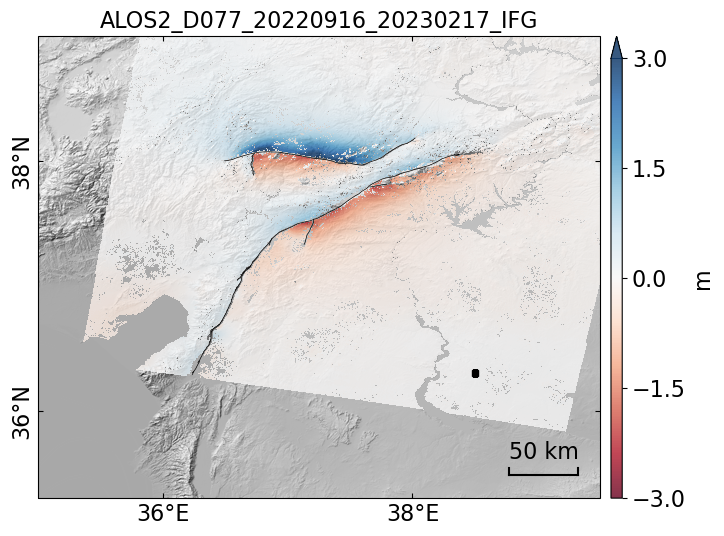

In [7]:
#unw_file = os.path.join(proj_dir, 'data_v2', dname, 'geo_filt_msk_ERA5_SET.unw')
unw_file = './geo/geo_filt_msk_ERA5_SET.unw'
out_file = os.path.join(proj_dir, f'notebooks/docs/{dname}_IFG.png')
cmd = f'{unw_file} phase --dem {dem_file} --dem-nocontour --shade-exag 0.05 --faultline {flt_file} '
cmd += f'-c RdBu -u m -v -3 3 --lalo-label --lalo-step 2 --ylabel-rot 90 --cbar-nbins 5 '
cmd += f'--scalebar 0.12 0.90 0.05 --title {dname}_IFG --ref-size 4 --math reverse '
cmd += f'-o {out_file} '
view.main(cmd.split())

view.py ./geo/ion_msk.geo band1 --title ionosphere --dem /Users/yunjunz/data/archives/2023TurkeyEQ/DEM/demLat_N35_N42_Lon_E034_E041_90m.h5 -c cmy -u radian --wrap --lalo-label --lalo-step 2 --ylabel-rot 90 --noreference --noverbose --save
Un-scalable display unit: radian


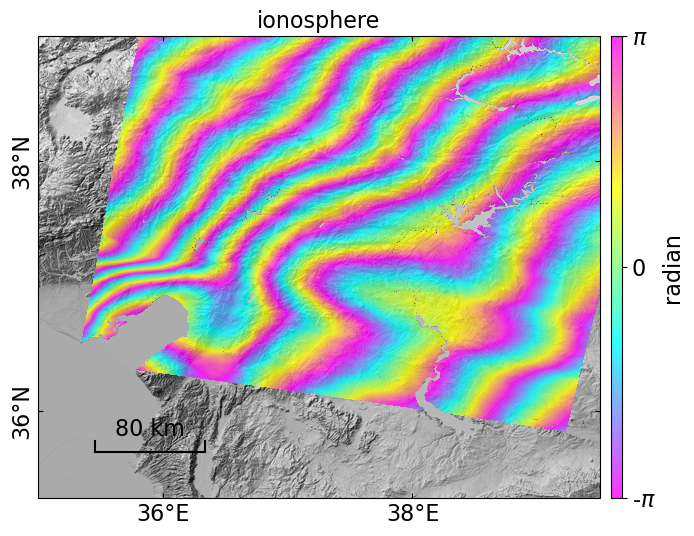

view.py ./geo/ERA5.h5 230217 --ref-date 220916 --title troposphere --dem /Users/yunjunz/data/archives/2023TurkeyEQ/DEM/demLat_N35_N42_Lon_E034_E041_90m.h5 -c cmy -u radian --wrap --lalo-label --lalo-step 2 --ylabel-rot 90 --noreference --noverbose --save


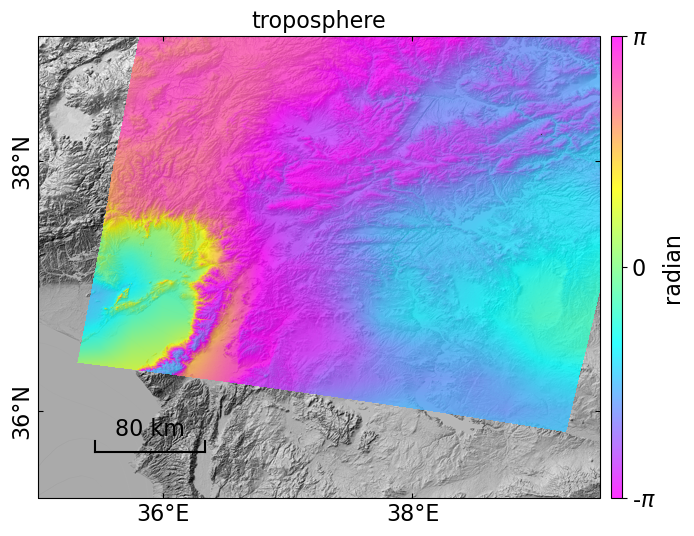

view.py ./geo/SET.h5 230217 --ref-date 220916 --dem /Users/yunjunz/data/archives/2023TurkeyEQ/DEM/demLat_N35_N42_Lon_E034_E041_90m.h5 -c cmy -u radian --wrap --lalo-label --lalo-step 2 --ylabel-rot 90 --noreference --noverbose --save --title solid Earth tides


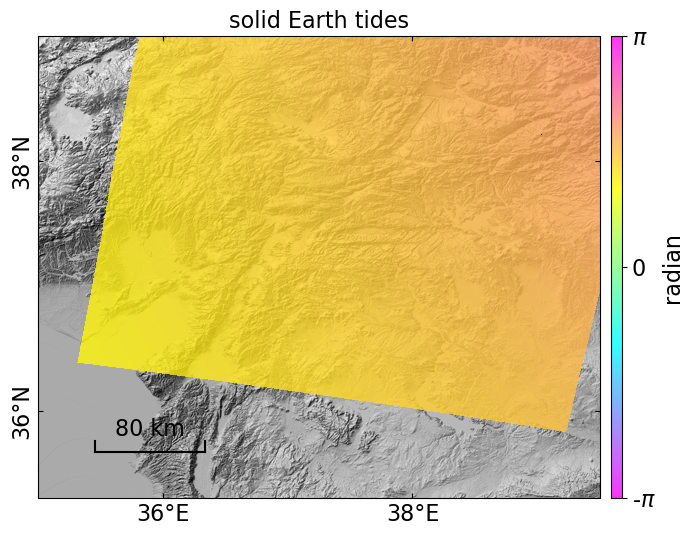

In [8]:
opt = f'--dem {dem_file} -c cmy -u radian --wrap --lalo-label --lalo-step 2 --ylabel-rot 90 --noreference --noverbose --save '
view.main(f'./geo/ion_msk.geo band1 --title ionosphere {opt} '.split())
view.main(f'./geo/ERA5.h5 {date2} --ref-date {date1} --title troposphere {opt} '.split())
view.main(f'./geo/SET.h5 {date2} --ref-date {date1} {opt} '.split() + ['--title', 'solid Earth tides'])